# Embedding Graphemes as Vectors

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tqdm

import re
import numpy as np
import os

In [4]:
import matplotlib.pyplot as plt


## Load and Process Grapheme Data

In [2]:
text = open("data/bbc_samp.adj")
processed_text = (re.sub(r'[^\w\s]','',text.read().lower()).replace('\n',' '))
tokens = [list("$"+token+"£") for token in processed_text.split(' ')]
vocab = list('abcdefghijklmnopqrstuvwxyz$£')
v = len(vocab)

## Create One Hot Vectors for Each Grapheme

In [3]:
def graph2int(graph):
    return vocab.index(graph)
    
def int2graph(index):
    return vocab[index]

def int2vec(integer):
    vec=np.zeros(len(vocab))
    vec[integer]=1
    return vec

def graph2vec(graph):
    return (int2vec(graph2int(graph)))

def vec2graph(vec):
    return (int2graph(np.argmax(vec)))

In [4]:
oneHotData = [[graph2vec(grapheme) for grapheme in word] for word in tokens]

## Build training data with labels
### Use windows to get surrounding words as labels, and context word as input

In [22]:
windowSize = 2
tokens = [tokenSet for tokenSet in tokens if len(tokenSet)>(2*windowSize+1)]
print(len(tokens))
c=0
for word in tokens:
   c+=len(word)-windowSize*2 

c=c*(windowSize*2)

x_trn = np.empty(shape=(c,len(vocab)))
y_trn = np.empty(shape=(c,len(vocab)))

i = 0

for word in tokens:
    wc = len(word)
    for graph_i in range(2,wc-2):
        x_trn[i:i+windowSize*2,:]=graph2vec(word[graph_i]) 
        y_trn[i,:] = graph2vec(word[graph_i-2])
        y_trn[i+1,:] = graph2vec(word[graph_i-1])
        y_trn[i+2,:] = graph2vec(word[graph_i+1])
        y_trn[i+3,:] = graph2vec(word[graph_i+2])
        i+=windowSize*2
        
print(x_trn.shape)
print(y_trn.shape)

4413
(63524, 28)
(63524, 28)


# PyTorch

In [6]:
class WordEmbeddingNetwork(nn.Module):
    def __init__(self,word_shape,embedding_units):
        super(WordEmbeddingNetwork,self).__init__()
        self.word_shape = word_shape
        self.embedding_units = embedding_units
        self.weights_encode = nn.Parameter(torch.empty(size=(embedding_units, word_shape[1]), requires_grad=True))
        self.weights_decode = nn.Parameter(torch.empty(size=(word_shape[1], embedding_units), requires_grad=True))
        
        nn.init.normal_(self.weights_encode)
        nn.init.normal_(self.weights_decode)
        
        self.bias1 = nn.Parameter(torch.zeros(embedding_units), requires_grad=True)
        self.bias2 = nn.Parameter(torch.zeros(word_shape[1]), requires_grad=True)
        
    def forward(self,inputs):
        out = F.linear(inputs, self.weights_encode, self.bias1)
        out = nn.ReLU().forward(out)
        out = F.linear(out, self.weights_decode,self.bias2)
        out = nn.ReLU().forward(out)
        return out

    def encode(self,inputs):
        out = F.linear(inputs, self.weights_encode, self.bias1)
        return out
        
        

In [1]:
w_net = WordEmbeddingNetwork(word_shape=x_trn.shape,embedding_units=2)
optimizer = optim.Adam(w_net.parameters(), amsgrad=False, weight_decay=0.0)

metric_dict = {'losses': []} 

batch_size = 256
samples = (int((x_trn.shape[0]/batch_size)))*batch_size
x_trn_t = torch.from_numpy(x_trn).float()[0:samples]
y_trn_t = torch.from_numpy(y_trn).float()[0:samples]

print(x_trn_t[0*batch_size:(0+1)*batch_size].shape)

for epoch in range(100):
    loss_val=0
    for row in tqdm.tqdm(range(int((x_trn_t.shape[0]/batch_size)))):
        training_batch = x_trn_t[row*batch_size:(row+1)*batch_size]

        label_batch = y_trn_t[row*batch_size:(row+1)*batch_size]
        
        out = w_net.forward(training_batch)
        log_softmax = F.log_softmax(out, dim=0)
        
        loss_fn = nn.MSELoss()
        RMSE_loss = torch.sqrt(loss_fn(out, label_batch))
    
        loss_val+=(RMSE_loss.item())
        
        optimizer.zero_grad()
        w_net.zero_grad()
        RMSE_loss.backward()
        optimizer.step()
    print("Epoch "+str(epoch)+" loss "+str(loss_val))
        
    metric_dict['losses'].append(loss_val)

NameError: name 'WordEmbeddingNetwork' is not defined

[0 1 2 3]
weights_
weights_


hello
[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]


([<matplotlib.axis.XTick at 0x7fdf2bbeaf10>,
 [Text(0, 0, 'weights_encode'),
  Text(1, 0, 'weights_decode'),
  Text(2, 0, 'bias1'),
  Text(3, 0, 'bias2')])

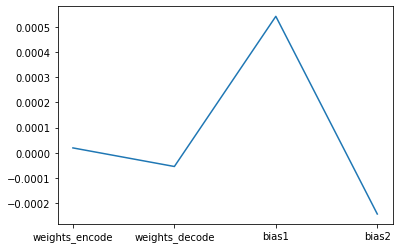

In [25]:
a=[]
layers=[]
ticks = np.arange(4)
print(ticks)

for layer, param in (w_net.named_parameters()):
    print(layer[:-6])
    a.append(param.grad.mean())
    layers.append(layer)
    
print("hello.weight"[:-7])    
plt.plot(a)
locs,labels=plt.xticks()
print(locs)
plt.xticks(ticks=ticks,labels=layers)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(28, 2)
(2, 2)


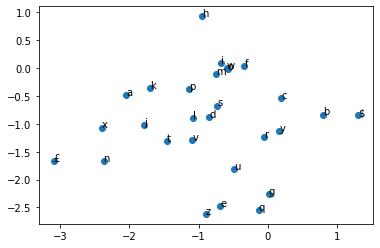

In [58]:
embeddings = np.zeros(shape=(len(vocab),2))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = w_net.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1

embedding_means = embeddings.mean(axis=0)
embedding_std = embeddings.std(axis=0)
norm_embeddings = (embeddings-embedding_means)/embedding_std

    
covariance_matrix = np.cov(norm_embeddings.T)
v,w = np.linalg.eig(covariance_matrix)

idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

variance_explained = []
for i in v:
     variance_explained.append((i/sum(v))*100)
        
red_Vecs = w[0:2,:]
print(red_Vecs)

print(embeddings.shape)
print(red_Vecs.shape)
low_d_embed = (embeddings @ red_Vecs.T)

#plt.scatter(x=low_d_embed[:,0],y=low_d_embed[:,1])

x=embeddings[:,0]
y=embeddings[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))

## Phonemes

In [44]:
text = open("data/combilex_rpc.dct")
textSamples=[['$']+phonemes.split(' ')[1:]+['£'] for phonemes in (text.read().split('\n'))]

tokenSet = [tokens for tokens in textSamples if len(tokens)>4]

vocab = list(set([token for tokens in tokenSet for token in tokens]))
print(vocab)
#processed_text = (re.sub(r'[^\w\s]','',text.read().lower()).replace('\n',' '))
#tokens = [list("$"+token+"£") for token in processed_text.split(' ')]
#vocab = list('abcdefghijklmnopqrstuvwxyz$£')
#v = len(vocab)

['ch', 'n', 'ae', 'ao', 'f', 'z', 'm', 'oy', 'hh', 'ow', 'ea', 'zh', 'ia', '$', 's', 'ay', 'uh', 'dh', 'ua', 'sh', 'jh', 'w', 'b', 'ng', 'eh', 'd', 'aw', 'oh', 'el', 'iy', 'em', 'er', 'ah', 'g', 't', 'y', 'ey', 'th', 'en', 'k', 'ih', 'r', 'uw', 'l', 'ax', '£', 'p', 'v', 'aa']


In [36]:
windowSize = 2

c=0
for word in tokenSet:
   c+=len(word)-windowSize*2 

c=c*(windowSize*2)

x_trn = np.empty(shape=(c,len(vocab)))
y_trn = np.empty(shape=(c,len(vocab)))

i = 0

for word in tokenSet:
    wc = len(word)
    for graph_i in range(2,wc-2):
        x_trn[i:i+windowSize*2,:]=graph2vec(word[graph_i]) 
        y_trn[i,:] = graph2vec(word[graph_i-2])
        y_trn[i+1,:] = graph2vec(word[graph_i-1])
        y_trn[i+2,:] = graph2vec(word[graph_i+1])
        y_trn[i+3,:] = graph2vec(word[graph_i+2])
        i+=windowSize*2
        
print(x_trn.shape)
print(y_trn.shape)

(3291464, 49)
(3291464, 49)


In [47]:
w_net = WordEmbeddingNetwork(word_shape=x_trn.shape,embedding_units=5)
optimizer = optim.Adam(w_net.parameters(), amsgrad=False, weight_decay=0.0)

metric_dict = {'losses': []} 

batch_size = 1024
samples = (int((x_trn.shape[0]/batch_size)))*batch_size
x_trn_t = torch.from_numpy(x_trn).float()[0:samples]
y_trn_t = torch.from_numpy(y_trn).float()[0:samples]

print(x_trn_t[0*batch_size:(0+1)*batch_size].shape)

for epoch in range(100):
    loss_val=0
    for row in tqdm.tqdm(range(int((x_trn_t.shape[0]/batch_size)))):
        training_batch = x_trn_t[row*batch_size:(row+1)*batch_size]

        label_batch = y_trn_t[row*batch_size:(row+1)*batch_size]
        
        out = w_net.forward(training_batch)
        log_softmax = F.log_softmax(out, dim=0)
        
        loss_fn = nn.MSELoss()
        RMSE_loss = torch.sqrt(loss_fn(out, label_batch))
    
        loss_val+=(RMSE_loss.item())
        
        optimizer.zero_grad()
        w_net.zero_grad()
        RMSE_loss.backward()
        optimizer.step()
    print("Epoch "+str(epoch)+" loss "+str(loss_val))
        
    metric_dict['losses'].append(loss_val)

  1%|          | 24/3214 [00:00<00:13, 234.18it/s]

torch.Size([1024, 49])


  2%|▏         | 75/3214 [00:00<00:09, 331.63it/s]

Epoch 0 loss 618.619069442153


  1%|          | 40/3214 [00:00<00:08, 391.08it/s]

Epoch 1 loss 458.17316319048405


  1%|          | 21/3214 [00:00<00:15, 206.19it/s]

Epoch 2 loss 457.8472149223089


  3%|▎         | 81/3214 [00:00<00:08, 376.09it/s]

Epoch 3 loss 457.5790084898472


  1%|          | 39/3214 [00:00<00:08, 382.59it/s]

Epoch 4 loss 456.9025910496712


  1%|          | 40/3214 [00:00<00:07, 398.51it/s]

Epoch 5 loss 456.7094427347183


  1%|          | 36/3214 [00:00<00:08, 356.29it/s]

Epoch 6 loss 456.524115011096


  1%|▏         | 41/3214 [00:00<00:07, 402.50it/s]

Epoch 7 loss 456.38092790544033


  1%|          | 38/3214 [00:00<00:08, 375.17it/s]

Epoch 8 loss 456.2722016721964


  1%|▏         | 41/3214 [00:00<00:07, 402.62it/s]

Epoch 9 loss 456.26408718526363


  1%|          | 28/3214 [00:00<00:11, 274.62it/s]

Epoch 10 loss 456.2605946213007


  1%|          | 36/3214 [00:00<00:08, 354.14it/s]

Epoch 11 loss 456.2559669613838


  1%|          | 35/3214 [00:00<00:09, 347.59it/s]

Epoch 12 loss 456.2540013343096


  1%|          | 37/3214 [00:00<00:08, 362.98it/s]

Epoch 13 loss 456.25300849974155


  1%|          | 37/3214 [00:00<00:08, 369.21it/s]

Epoch 14 loss 456.24846379458904


  1%|          | 31/3214 [00:00<00:10, 309.23it/s]

Epoch 15 loss 456.24310636520386


  1%|          | 32/3214 [00:00<00:10, 316.53it/s]

Epoch 16 loss 456.2393311262131


  1%|          | 29/3214 [00:00<00:11, 287.26it/s]

Epoch 17 loss 456.23626959323883


  1%|          | 35/3214 [00:00<00:09, 345.04it/s]

Epoch 18 loss 456.1281324326992


  1%|          | 24/3214 [00:00<00:13, 235.14it/s]

Epoch 19 loss 456.028475433588


  1%|          | 26/3214 [00:00<00:12, 257.74it/s]

Epoch 20 loss 456.00789868831635


  1%|          | 30/3214 [00:00<00:10, 298.51it/s]

Epoch 21 loss 456.0060045719147


  1%|          | 31/3214 [00:00<00:10, 309.95it/s]

Epoch 22 loss 456.0043425858021


  1%|          | 33/3214 [00:00<00:09, 324.28it/s]

Epoch 23 loss 456.0026610791683


  1%|          | 27/3214 [00:00<00:11, 269.91it/s]

Epoch 24 loss 455.9894015043974


  1%|          | 34/3214 [00:00<00:09, 330.63it/s]

Epoch 25 loss 455.2375339716673


  1%|          | 31/3214 [00:00<00:10, 301.57it/s]

Epoch 26 loss 454.304604947567


  1%|▏         | 41/3214 [00:00<00:07, 402.44it/s]

Epoch 27 loss 454.00180508196354


  1%|          | 40/3214 [00:00<00:08, 396.70it/s]

Epoch 28 loss 453.4266656935215


  1%|▏         | 41/3214 [00:00<00:07, 401.52it/s]

Epoch 29 loss 453.3741148263216


  2%|▏         | 80/3214 [00:00<00:07, 400.57it/s]

Epoch 30 loss 453.3232942521572


  2%|▏         | 49/3214 [00:00<00:06, 477.70it/s]

Epoch 31 loss 453.3195192068815


  1%|          | 33/3214 [00:00<00:09, 323.62it/s]

Epoch 32 loss 453.3189223110676


  3%|▎         | 86/3214 [00:00<00:07, 420.23it/s]

Epoch 33 loss 452.21623036265373


  1%|          | 32/3214 [00:00<00:09, 319.50it/s]

Epoch 34 loss 451.92251604795456


  1%|          | 34/3214 [00:00<00:09, 325.79it/s]

Epoch 35 loss 451.8918738514185


  3%|▎         | 86/3214 [00:00<00:07, 412.75it/s]

Epoch 36 loss 451.799396276474


  2%|▏         | 78/3214 [00:00<00:08, 381.19it/s]

Epoch 37 loss 451.3702385574579


  1%|          | 40/3214 [00:00<00:07, 398.37it/s]

Epoch 38 loss 451.2566209733486


  1%|          | 38/3214 [00:00<00:08, 374.92it/s]

Epoch 39 loss 451.1120870709419


  1%|          | 36/3214 [00:00<00:08, 354.17it/s]

Epoch 40 loss 451.11079989373684


  1%|          | 36/3214 [00:00<00:08, 359.01it/s]

Epoch 41 loss 451.11006942391396


  1%|▏         | 41/3214 [00:00<00:07, 399.40it/s]

Epoch 42 loss 451.10997216403484


  1%|          | 22/3214 [00:00<00:14, 219.43it/s]

Epoch 43 loss 451.1094678044319


  1%|          | 34/3214 [00:00<00:09, 336.04it/s]

Epoch 44 loss 451.11160315573215


  1%|▏         | 41/3214 [00:00<00:07, 400.50it/s]

Epoch 45 loss 451.1088529378176


  1%|▏         | 44/3214 [00:00<00:07, 432.43it/s]

Epoch 46 loss 451.10864098370075


  1%|          | 37/3214 [00:00<00:08, 355.17it/s]

Epoch 47 loss 451.1081791073084


  1%|          | 34/3214 [00:00<00:09, 331.03it/s]

Epoch 48 loss 451.10818226635456


  1%|          | 37/3214 [00:00<00:08, 363.60it/s]

Epoch 49 loss 451.108442530036


  1%|          | 35/3214 [00:00<00:09, 344.03it/s]

Epoch 50 loss 451.10799539089203


  1%|          | 26/3214 [00:00<00:12, 257.51it/s]

Epoch 51 loss 451.0093333274126


  0%|          | 13/3214 [00:00<00:25, 126.76it/s]

Epoch 52 loss 450.4946984052658


  1%|          | 21/3214 [00:00<00:15, 209.54it/s]

Epoch 53 loss 450.4940186589956


  1%|▏         | 47/3214 [00:00<00:06, 469.36it/s]

Epoch 54 loss 450.49395774304867


  1%|          | 39/3214 [00:00<00:08, 384.18it/s]

Epoch 55 loss 450.4939398318529


  0%|          | 14/3214 [00:00<00:26, 121.96it/s]

Epoch 56 loss 450.49260994791985


  1%|          | 30/3214 [00:00<00:10, 298.51it/s]

Epoch 57 loss 450.490523904562


  1%|▏         | 42/3214 [00:00<00:07, 412.21it/s]

Epoch 58 loss 450.4904795587063


  3%|▎         | 81/3214 [00:00<00:07, 393.07it/s]

Epoch 59 loss 450.4904522448778


  1%|▏         | 42/3214 [00:00<00:07, 412.16it/s]

Epoch 60 loss 450.49044485390186


  1%|▏         | 42/3214 [00:00<00:07, 415.21it/s]

Epoch 61 loss 450.4904229193926


  1%|▏         | 42/3214 [00:00<00:07, 412.97it/s]

Epoch 62 loss 450.490408167243


  3%|▎         | 87/3214 [00:00<00:07, 420.35it/s]

Epoch 63 loss 450.49038641154766


  1%|▏         | 42/3214 [00:00<00:07, 413.04it/s]

Epoch 64 loss 450.49036982655525


  1%|▏         | 42/3214 [00:00<00:07, 415.36it/s]

Epoch 65 loss 450.49034617841244


  1%|          | 31/3214 [00:00<00:10, 308.26it/s]

Epoch 66 loss 450.4903614670038


  1%|▏         | 42/3214 [00:00<00:07, 407.31it/s]

Epoch 67 loss 450.4906283169985


  1%|          | 40/3214 [00:00<00:08, 392.33it/s]

Epoch 68 loss 450.4906251132488


  1%|▏         | 42/3214 [00:00<00:07, 413.09it/s]

Epoch 69 loss 450.4906461685896


  3%|▎         | 88/3214 [00:00<00:07, 430.16it/s]

Epoch 70 loss 450.4906410127878


  3%|▎         | 89/3214 [00:00<00:07, 442.96it/s]

Epoch 71 loss 450.4906611889601


  1%|▏         | 44/3214 [00:00<00:07, 432.22it/s]

Epoch 72 loss 450.4906544983387


  1%|          | 39/3214 [00:00<00:08, 387.86it/s]

Epoch 73 loss 450.4906469285488


  1%|▏         | 42/3214 [00:00<00:07, 415.81it/s]

Epoch 74 loss 450.4906437397003


  1%|▏         | 41/3214 [00:00<00:07, 409.92it/s]

Epoch 75 loss 450.4906360656023


  1%|▏         | 42/3214 [00:00<00:07, 413.82it/s]

Epoch 76 loss 450.49063043296337


  1%|          | 40/3214 [00:00<00:08, 393.83it/s]

Epoch 77 loss 450.4906267076731


  1%|▏         | 41/3214 [00:00<00:07, 408.72it/s]

Epoch 78 loss 450.4906243085861


  1%|▏         | 41/3214 [00:00<00:07, 403.87it/s]

Epoch 79 loss 450.49062190949917


  1%|          | 39/3214 [00:00<00:08, 388.16it/s]

Epoch 80 loss 450.4906201213598


  0%|          | 3/3214 [00:00<01:53, 28.30it/s]

Epoch 81 loss 450.49102924764156


  1%|▏         | 45/3214 [00:00<00:07, 444.09it/s]

Epoch 82 loss 450.4911292642355


  1%|          | 35/3214 [00:00<00:09, 344.22it/s]

Epoch 83 loss 450.4911306351423


  1%|▏         | 42/3214 [00:00<00:07, 415.16it/s]

Epoch 84 loss 450.4911314100027


  3%|▎         | 88/3214 [00:00<00:07, 423.39it/s]

Epoch 85 loss 450.4911256432533


  1%|▏         | 41/3214 [00:00<00:07, 407.85it/s]

Epoch 86 loss 450.4911238104105


  1%|          | 37/3214 [00:00<00:08, 365.15it/s]

Epoch 87 loss 450.49112179875374


  1%|▏         | 43/3214 [00:00<00:07, 424.35it/s]

Epoch 88 loss 450.4911196231842


  3%|▎         | 84/3214 [00:00<00:07, 401.50it/s]

Epoch 89 loss 450.49111707508564


  1%|▏         | 41/3214 [00:00<00:07, 405.67it/s]

Epoch 90 loss 450.4911147505045


  1%|▏         | 42/3214 [00:00<00:07, 418.11it/s]

Epoch 91 loss 450.4911167919636


  1%|▏         | 43/3214 [00:00<00:07, 424.57it/s]

Epoch 92 loss 450.49111871421337


  1%|▏         | 43/3214 [00:00<00:07, 424.21it/s]

Epoch 93 loss 450.49111419916153


  1%|          | 40/3214 [00:00<00:07, 397.19it/s]

Epoch 94 loss 450.49111396074295


  3%|▎         | 87/3214 [00:00<00:07, 424.73it/s]

Epoch 95 loss 450.4911126792431


  1%|          | 35/3214 [00:00<00:09, 346.31it/s]

Epoch 96 loss 450.491109341383


  1%|          | 32/3214 [00:00<00:12, 263.17it/s]

Epoch 97 loss 450.4911108613014


  1%|▏         | 41/3214 [00:00<00:07, 404.30it/s]

Epoch 98 loss 450.49111184477806


100%|██████████| 3214/3214 [00:07<00:00, 430.57it/s]

Epoch 99 loss 450.49111157655716


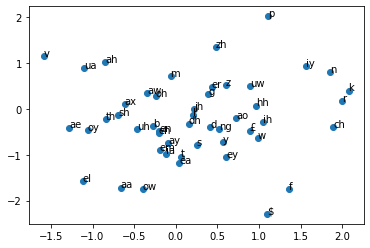

In [48]:
embeddings = np.zeros(shape=(len(vocab),5))

i=0
for grapheme in vocab:
    test = torch.from_numpy(graph2vec(grapheme)).float()
    embedding = w_net.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1

embedding_means = embeddings.mean(axis=0)
embedding_std = embeddings.std(axis=0)
norm_embeddings = (embeddings-embedding_means)/embedding_std

    
covariance_matrix = np.cov(norm_embeddings.T)
v,w = np.linalg.eig(covariance_matrix)

idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

variance_explained = []
for i in v:
     variance_explained.append((i/sum(v))*100)
        
red_Vecs = w[0:2,:]

low_d_embed = (embeddings @ red_Vecs.T)

#plt.scatter(x=low_d_embed[:,0],y=low_d_embed[:,1])

x=low_d_embed[:,0]
y=low_d_embed[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))

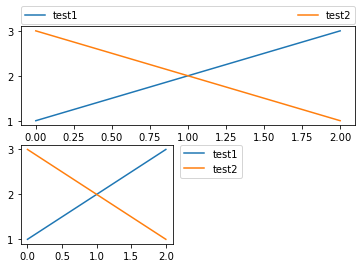

In [5]:
plt.subplot(211)
plt.plot([1, 2, 3], label="test1")
plt.plot([3, 2, 1], label="test2")

# Place a legend above this subplot, expanding itself to
# fully use the given bounding box.
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

plt.subplot(223)
plt.plot([1, 2, 3], label="test1")
plt.plot([3, 2, 1], label="test2")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()